In [1]:
import os,argparse,time
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
from dataloaders.deep_moji import DeepMojiDataset
from networks.deepmoji_sa import DeepMojiModel

In [4]:
from networks.eval_metrices import group_evaluation

In [5]:
from tqdm import tqdm, trange

In [6]:
# reproducibility

# DataLoader Parameters
params = {'batch_size': 1024,
          'shuffle': False,
          'num_workers': 0}
# Device
device = torch.device("cuda")


In [7]:
class Args:
    use_fp16 = False
    cuda = "cuda"
    hidden_size = 300
    emb_size = 2304
    num_classes = 2
    adv = False
    adv_level = -1
    lr = 3e-5
    LAMBDA = 1e-4 # adversarial 
    adv_units = 256
    ratio = 0.8
    
data_path = "D:\\Project\\User_gender_removal\\data\\deepmoji\\split2\\"
args = Args()
args.device = device

In [8]:
split = "train"
train_data = DeepMojiDataset(args, data_path, split, ratio=args.ratio)

Loading preprocessed deepMoji Encoded data
Done, loaded data shapes: (99998, 2304), (99998,), (99998,)


In [9]:
dev_data = DeepMojiDataset(args, data_path, "dev", n=200000, ratio=args.ratio)

Loading preprocessed deepMoji Encoded data
Done, loaded data shapes: (8000, 2304), (8000,), (8000,)


In [10]:
test_data = DeepMojiDataset(args, data_path, "test", n=200000, ratio=args.ratio)

Loading preprocessed deepMoji Encoded data
Done, loaded data shapes: (7998, 2304), (7998,), (7998,)


In [11]:
training_generator = torch.utils.data.DataLoader(train_data, **params)
validation_generator = torch.utils.data.DataLoader(dev_data, **params)
test_generator = torch.utils.data.DataLoader(test_data, **params)

In [12]:
model = DeepMojiModel(args)
model = model.to(device)

In [13]:
model.load_state_dict(torch.load("models\\deepmoji_model.pt"))

<All keys matched successfully>

# INLP Debiasing

In [14]:
model.eval()
model.adv_level = -1

train_hidden = []
train_labels = []
train_private_labels = []

for batch in training_generator:
    text = batch[0]
    tags = batch[1]
    p_tags = batch[2]
    train_labels += list(tags.cpu().numpy() )
    train_private_labels += list(p_tags.cpu().numpy())
    
    text = text.to(device)
    hidden_state = model.hidden(text)
    train_hidden.append(hidden_state.detach().cpu().numpy())
train_hidden = np.concatenate(train_hidden, 0)
dev_hidden = []
dev_labels = []
dev_private_labels = []
for batch in validation_generator:
    text = batch[0]
    tags = batch[1]
    p_tags = batch[2]
    dev_labels += list(tags.cpu().numpy() )
    dev_private_labels += list(p_tags.cpu().numpy())
    
    text = text.to(device)
    hidden_state = model.hidden(text)
    dev_hidden.append(hidden_state.detach().cpu().numpy())
dev_hidden = np.concatenate(dev_hidden, 0)
test_hidden = []
test_labels = []
test_private_labels = []
for batch in test_generator:
    text = batch[0]
    tags = batch[1]
    p_tags = batch[2]
    test_labels += list(tags.cpu().numpy() )
    test_private_labels += list(p_tags.cpu().numpy())
    
    text = text.to(device)
    hidden_state = model.hidden(text)
    test_hidden.append(hidden_state.detach().cpu().numpy())
test_hidden = np.concatenate(test_hidden, 0)

In [15]:
train_hidden = np.array(train_hidden)
train_labels = np.array(train_labels)
train_private_labels = np.array(train_private_labels)
dev_hidden = np.array(dev_hidden)
dev_labels = np.array(dev_labels)
dev_private_labels = np.array(dev_private_labels)
test_hidden = np.array(test_hidden)
test_labels = np.array(test_labels)
test_private_labels = np.array(test_private_labels)

In [16]:
from INLP.debias import get_debiasing_projection
from INLP.debias import get_projection_to_intersection_of_nullspaces

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [17]:
is_autoregressive = True
min_acc = 0.51
noise = False
n = 300
dim = 300

clf = LinearSVC
params = {'fit_intercept': True, 'class_weight': 'balanced', 'dual': False, 'C': 0.1}

In [18]:
P_n = get_debiasing_projection(clf, params, n, dim, is_autoregressive, min_acc,
                                train_hidden, train_private_labels, dev_hidden, dev_private_labels,
                                by_class=True, Y_train_main=train_labels, Y_dev_main=dev_labels)

iteration: 299, accuracy: 0.5015: 100%|██████████| 300/300 [09:35<00:00,  1.92s/it]


In [28]:
%store P_n

Stored 'P_n' (tuple)


In [19]:
from collections import Counter, defaultdict

def get_TPR(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            # print(sum(used_vals))
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

In [20]:
rowspaces = P_n[1]

from collections import defaultdict

ratio_tradeoff = defaultdict(dict)

for p_iteration in tqdm(range(1, len(rowspaces))):
    
    P = get_projection_to_intersection_of_nullspaces(rowspaces[:p_iteration], input_dim=300)
    
    debiased_x_train = P.dot(train_hidden.T).T
    debiased_x_dev = P.dot(dev_hidden.T).T
    
    classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    classifier.fit(debiased_x_train, train_labels)
    debiased_score = classifier.score(debiased_x_dev, dev_labels)
    
    _, debiased_diffs = get_TPR(dev_labels, classifier.predict(debiased_x_dev), dev_private_labels)
    
    ratio_tradeoff[p_iteration]['debiased_diff_tpr'] = debiased_diffs['y:1']
    ratio_tradeoff[p_iteration]['debiased_diff_tnr'] = debiased_diffs['y:0']
    ratio_tradeoff[p_iteration]['debiased_acc'] = debiased_score

100%|██████████| 35/35 [01:40<00:00,  2.87s/it]


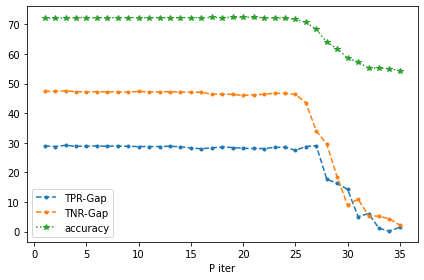

In [21]:
import matplotlib.pyplot as plt
def data2plot(iteration, TPR_GAP, TNR_GAP, ACC, x_label=None, y_label=None, title=None):

    # label is optional, and is used for the legend
    # here, the third arguemtns are a mix of the `marker' and the `linestyle'
    ax = plt.plot(iteration, TPR_GAP, '.--', label='TPR-Gap')
    ax = plt.plot(iteration, TNR_GAP, '.--', label='TNR-Gap')
    ax = plt.plot(iteration, ACC, '*:', label='accuracy')

    if y_label:
        plt.ylabel(y_label)
    if x_label:
        plt.xlabel(x_label)
    if title:
        plt.title(title)

    plt.legend(loc='lower left', frameon=True)
    
    plt.tight_layout()
    plt.show()
    
data2plot(list(ratio_tradeoff.keys()),
          [100*abs(x['debiased_diff_tpr']) for x in ratio_tradeoff.values()],
          [100*abs(x['debiased_diff_tnr']) for x in ratio_tradeoff.values()],
          [100*x['debiased_acc'] for x in ratio_tradeoff.values()], 'P iter', title='')

In [22]:
# select an iteration from INLP results
candidate_results = []
for k in ratio_tradeoff.keys():
    iteration_results = ratio_tradeoff[k]
    if (abs(iteration_results['debiased_diff_tpr']) + abs(iteration_results['debiased_diff_tnr'])) <= 0.7:
        if iteration_results['debiased_acc'] > 0.65:
            candidate_results.append(
                (
                    iteration_results["debiased_acc"], 
                    abs(iteration_results['debiased_diff_tpr']), 
                    abs(iteration_results['debiased_diff_tnr']),
                    k
                )
            )
selected_keys = sorted(candidate_results, reverse=True)[0][3]

In [23]:
print(ratio_tradeoff[selected_keys])

{'debiased_diff_tpr': -0.2905, 'debiased_diff_tnr': 0.34049999999999997, 'debiased_acc': 0.68325}


In [24]:
P, rowspace_projections, Ws = P_n 
n_dims = selected_keys
P = get_projection_to_intersection_of_nullspaces(rowspace_projections[:n_dims], input_dim=300)

In [25]:
debiased_x_train = P.dot(train_hidden.T).T
debiased_x_dev = P.dot(dev_hidden.T).T
debiased_x_test = P.dot(test_hidden.T).T

In [26]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
linear_attacker = LogisticRegression()
linear_attacker.fit(debiased_x_train, train_private_labels)

LogisticRegression()

In [27]:
linear_attacker.score(debiased_x_dev, dev_private_labels)

0.659